# Topic modeling without Theta distribution

Based on unpublished (yet) research by Ilya Irhin, Victor Bulatov, Konstantin Vorontsov

One of the interpretations of topic modeling is this:

\begin{equation}
L(\Phi, \Theta) + R(\Phi, \Theta) \to \max_{\Phi, \Theta},
\end{equation}

Once the inference is directly formulated as an optimization problem, one can ask: is it possible to reduce the number f inferred parameters? 

In the practice, word-topic matrix $(\Phi)$ has a larger importance than document-topic matrix $(\Theta)$; so we can replace the original optimization problem with a different one:

\begin{equation}
L(\Phi, f(\Phi) ) + R(\Phi, f(\Phi) ) \to \max_{\Phi},
\end{equation}

Some math later, it turns out that the "formally correct" optimization algorithm for this problem is different from conventional EM algorithm, and has some surprising advantages. Technically speaking, these formulas require a different iteration process (which is implemented here: https://github.com/ilirhin/python_artm), but the formulas look similar enough to a custom $\Phi$ regularizer (if one sets `num_document_passes=1` in BigARTM)

This notebook serves as a proof-of-concept for this idea.


In [1]:
import sys
sys.path.insert(0, '../..')

In [2]:
import numpy as np
import pandas as pd
import requests
import scipy.sparse

from numba import jit
from numpy import random
from matplotlib import pyplot as plt

import artm

from topicnet.cooking_machine.dataset import Dataset
from topicnet.cooking_machine.models import (
    BaseScore as BaseTopicNetScore,
    TopicModel
)
from topicnet.cooking_machine.models.base_regularizer import BaseRegularizer
from topicnet.cooking_machine.models.topic_prior_regularizer import TopicPriorRegularizer
from topicnet.cooking_machine.models.thetaless_regularizer import (
    ThetalessRegularizer,
    dataset2sparse_matrix,
)

from topicnet.viewers.top_tokens_viewer import TopTokensViewer
from topicnet.viewers.top_documents_viewer import TopDocumentsViewer

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
dataset = Dataset(
    "/data/datasets/20_News_dataset/20NG_BOW.csv",
    internals_folder_path="./20NG_internals",
)

dataset.get_possible_modalities()

{'@footer', '@header', '@word'}

In [5]:
MAIN_MODALITY = "@word"

## Preparing the coherence score

### Top-token coherence (co-occurrences are calculated using the same corpus)


In [6]:
def calc_doc_occurrences(dataset, modality):
    """
    :param n_dw_matrix: sparse document-word matrix, shape is D x W
    :return: sparse matrix of co-occurrences

    doc_occurrences[w1, w2] = the number of the documents
    where there are w1 and w2
    """
    n_dw_matrix = dataset2sparse_matrix(dataset, modality, modalities_to_use=[modality])
    matrix = (scipy.sparse.csc_matrix(n_dw_matrix) > 0).astype(int)
    co_occurrences = matrix.T * matrix

    return co_occurrences.diagonal(), co_occurrences


def create_pmi_top_function(
    doc_occurrences, doc_co_occurrences,
    documents_number, top_sizes,
    co_occurrences_smooth=1.
):
    """
    :param doc_occurrences: array of doc occurrences of words
    :param doc_co_occurrences: sparse matrix of doc co-occurrences of words
    :param documents_number: number of the documents
    :param top_sizes: list of top values to calculate top-pmi for
    :param co_occurrences_smooth: constant to smooth co-occurrences in log
    :return: function which takes phi and theta and returns
    pair of two arrays: pmi-s of the tops and ppmi-s of the tops

    pmi[i] - pmi(top of size top_sizes[i])
    ppmi[i] - ppmi(top of size top_sizes[i])

    pmi(words) = sum_{u in words, v in words, u != v}
    log(
        (doc_co_occurrences[u, v] * documents_number + co_occurrences_smooth)
        / doc_occurrences[u] / doc_occurrences[v]
    )

    ppmi(words) = sum_{u in words, v in words, u != v}
    max(log(
        (doc_co_occurrences[u, v] * documents_number + co_occurrences_smooth)
        / doc_occurrences[u] / doc_occurrences[v]
    ), 0)

    """
    def func(phi):
        T, W = phi.shape
        max_top_size = max(top_sizes)
        pmi, ppmi = np.zeros(max_top_size), np.zeros(max_top_size)
        tops = np.argpartition(phi, -max_top_size, axis=1)[:, -max_top_size:]
        
        for t in range(T):
            top = sorted(tops[t], key=lambda w: - phi[t, w])
            co_occurrences = doc_co_occurrences[top, :][:, top].todense()
            occurrences = doc_occurrences[top]
            values = np.log(
                (co_occurrences * documents_number + co_occurrences_smooth)
                / (occurrences[:, np.newaxis] * occurrences[np.newaxis, :] + co_occurrences_smooth)
            )
            diag = np.diag_indices(len(values))
            values.cumsum(axis=0).cumsum(axis=1)[diag] - values[diag].cumsum()
            pmi += np.array(
               values.cumsum(axis=0).cumsum(axis=1)[diag] - values[diag].cumsum()
            ).ravel()

            values[values < 0.] = 0.
            ppmi += np.array(
               values.cumsum(axis=0).cumsum(axis=1)[diag] - values[diag].cumsum()
            ).ravel()
            
        sizes = np.arange(2, max_top_size + 1)
        pmi[1:] /= (T * sizes * (sizes - 1))
        ppmi[1:] /= (T * sizes * (sizes - 1))
        indices = np.array(top_sizes) - 1
        
        return pmi[indices], ppmi[indices]

    return func

In [8]:
%%time

occurences, co_occurences = calc_doc_occurrences(dataset, MAIN_MODALITY)

calc_pmi = create_pmi_top_function(
    occurences, co_occurences,
    dataset.get_dataset().shape[0], [20],
    co_occurrences_smooth=1e-2,
)

CPU times: user 9.41 s, sys: 1.27 s, total: 10.7 s
Wall time: 10.6 s


In [9]:
class TopTokenCoherence(BaseTopicNetScore):
    def __init__(self, func):
        super().__init__()

        self.calc_pmi = func

    def call(self, model: TopicModel):
        values = self.calc_pmi(model.get_phi_dense()[0].T)

        return values[1]

### Model training

In [10]:
thetaless_reg = ThetalessRegularizer(
    name='thetaless', 
    tau=1,
    dataset=dataset, 
    modality=MAIN_MODALITY,
)

sparse_reg = artm.regularizers.SmoothSparsePhiRegularizer(
    name='sparse_reg', 
    tau=-0.5,
)

In [11]:
def create_model(dataset, modality: str):
    model = artm.ARTM(num_topics=30, num_document_passes=1, class_ids={modality: 1.0})
    model.initialize(dataset.get_dictionary())
    
    model.scores.add(
        artm.scores.PerplexityScore(name='perplexity', class_ids=[modality])
    )
    model.scores.add(
        artm.scores.SparsityPhiScore(name='sparsity', class_id=modality)
    )
    model.scores.add(
        artm.scores.TopicKernelScore(name='kernel', class_id=modality)
    )
    
    return model

In [13]:
NUM_FIT_ITERATIONS = 50

In [12]:
plsa_model = TopicModel(
    artm_model=create_model(dataset, MAIN_MODALITY), 
    model_id='plsa_model',
    custom_scores={
        "coherence_ppmi": TopTokenCoherence(calc_pmi)
    }
)

%time plsa_model._fit(dataset.get_batch_vectorizer(), NUM_FIT_ITERATIONS)

CPU times: user 4min 7s, sys: 9.59 s, total: 4min 16s
Wall time: 1min 30s


In [14]:
thetaless_model = TopicModel(
    artm_model=create_model(dataset, MAIN_MODALITY), 
    model_id='thetaless_model',
    custom_regularizers={
        thetaless_reg.name: thetaless_reg
    },
    custom_scores={
        "coherence_ppmi": TopTokenCoherence(calc_pmi)
    }
)

%time thetaless_model._fit(dataset.get_batch_vectorizer(), NUM_FIT_ITERATIONS)

CPU times: user 6min 4s, sys: 37.7 s, total: 6min 42s
Wall time: 3min 18s


In [15]:
artm_model = create_model(dataset, MAIN_MODALITY)
artm_model.regularizers.add(sparse_reg)

sparse_model = TopicModel(
    artm_model=artm_model, 
    model_id='sparse_model',
    custom_scores={"coherence_ppmi": TopTokenCoherence(calc_pmi)}
)

%time sparse_model._fit(dataset.get_batch_vectorizer(), NUM_FIT_ITERATIONS)

CPU times: user 4min 21s, sys: 27.5 s, total: 4min 48s
Wall time: 1min 45s


In [16]:
artm_model = create_model(dataset, MAIN_MODALITY)
artm_model.regularizers.add(sparse_reg)

sparse_thetaless_model = TopicModel(
    artm_model=artm_model, 
    model_id='sparse_thetaless_model',
    custom_regularizers={
        thetaless_reg.name: thetaless_reg
    },
    custom_scores={
        "coherence_ppmi": TopTokenCoherence(calc_pmi)
    }
)

%time sparse_thetaless_model._fit(dataset.get_batch_vectorizer(), NUM_FIT_ITERATIONS)

CPU times: user 7min 1s, sys: 1min 20s, total: 8min 21s
Wall time: 3min 49s


## Quality Visualizing

In [17]:
def plot_metric(view_name, value_name, title_name):
    plt.figure(figsize=(14,8))

    plt.subplot(2,2,1)
    values = np.array(getattr(thetaless_model.score_tracker[view_name], value_name))
    med = np.median(values)
    values[values > 5 * med] = np.nan
    last_thetaless = values[-1]

    plt.title(f'{title_name} with Thetaless regularizer')
    plt.plot(values[1:])

    plt.subplot(2,2,2)
    values = np.array(getattr(plsa_model.score_tracker[view_name], value_name))
    med = np.median(values)
    values[values > 5 * med] = np.nan
    last_plsa = values[-1]
    
    plt.title(f'{title_name} without any regularization')
    plt.plot(values[1:])
    
    plt.subplot(2,2,3)
    values = np.array(getattr(sparse_model.score_tracker[view_name], value_name))
    med = np.median(values)
    values[values > 5 * med] = np.nan
    last_sparse = values[-1]

    plt.title(f'{title_name} with sparsity regularizer')
    plt.plot(values[1:])
    
    plt.subplot(2,2,4)
    values = np.array(getattr(sparse_thetaless_model.score_tracker[view_name], value_name))
    med = np.median(values)
    values[values > 5 * med] = np.nan
    last_sparse_thetaless = values[-1]

    plt.title(f'{title_name} with both regularizers')
    plt.plot(values[1:])
    
    print(
        f'Last values:\n\t'
        f'thetaless – {last_thetaless}\n\t'
        f'plsa – {last_plsa}\n\t'
        f'sparse – {last_sparse}\n\t'
        f'sparse_thetaless – {last_sparse_thetaless}\n\t' 
    )

    plt.show()

Last values:
	thetaless – 1787.9063720703125
	plsa – 1876.0892333984375
	sparse – 1317.7843017578125
	sparse_thetaless – 1274.2459716796875
	


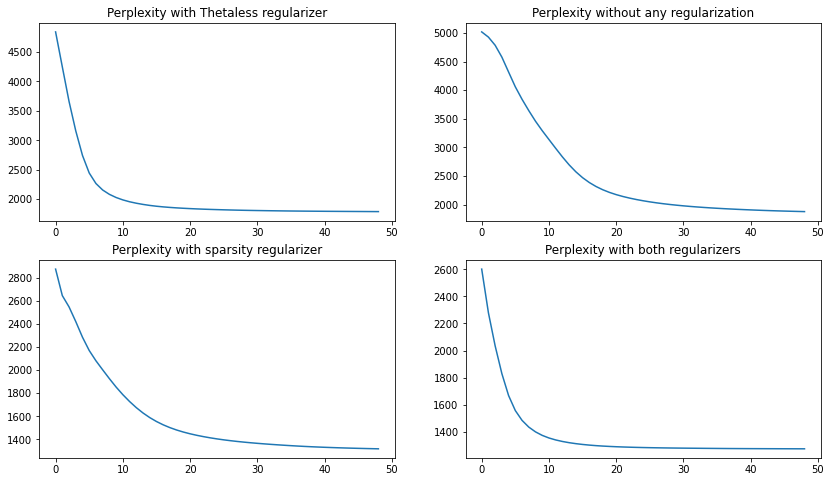

In [18]:
plot_metric(view_name='perplexity', value_name='value', title_name='Perplexity')

Last values:
	thetaless – 0.93656986951828
	plsa – 0.8662593960762024
	sparse – 0.9919413924217224
	sparse_thetaless – 0.9935382604598999
	


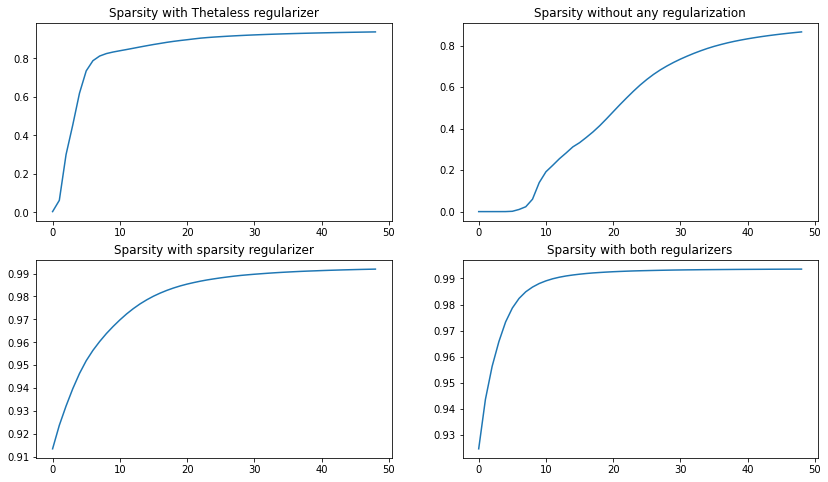

In [19]:
plot_metric(view_name='sparsity', value_name='value', title_name='Sparsity')

Last values:
	thetaless – 0.7902413010597229
	plsa – 0.7366632223129272
	sparse – 0.8241350650787354
	sparse_thetaless – 0.8964435458183289
	


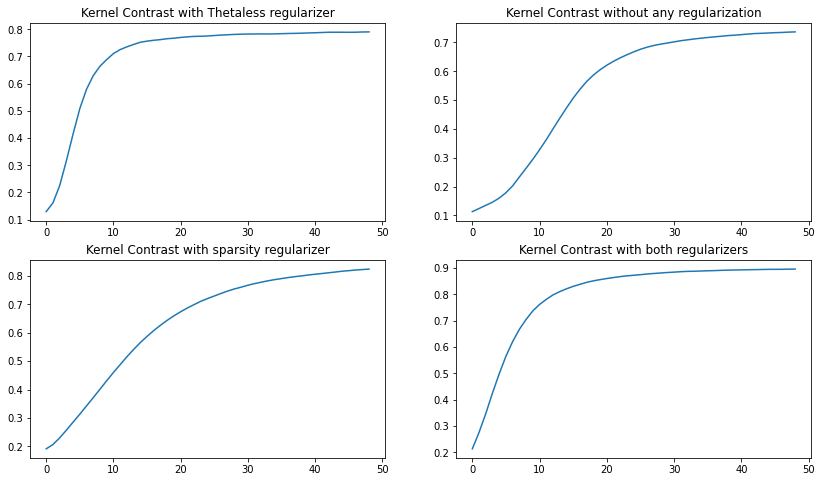

In [20]:
plot_metric(view_name='kernel', value_name='average_contrast', title_name='Kernel Contrast')

Last values:
	thetaless – 0.9562450051307678
	plsa – 0.8865759372711182
	sparse – 0.9308170080184937
	sparse_thetaless – 0.9824467897415161
	


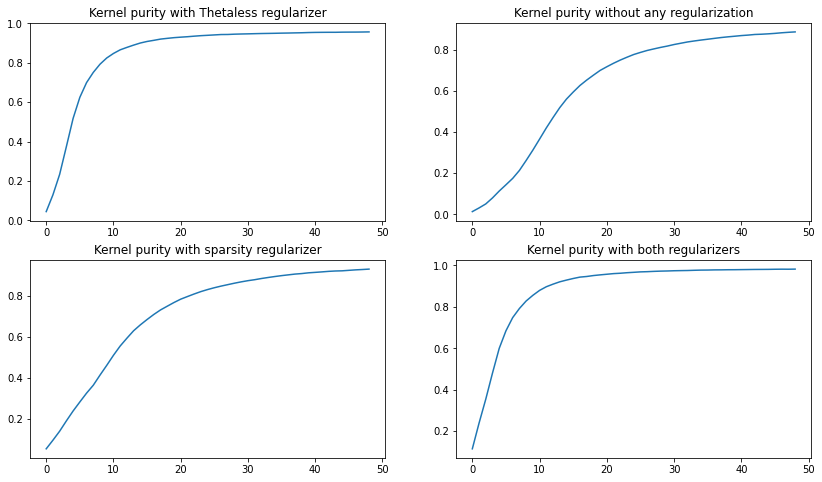

In [21]:
plot_metric(view_name='kernel', value_name='average_purity', title_name='Kernel purity')

Last values:
	thetaless – 4043.699951171875
	plsa – 4254.63330078125
	sparse – 663.4000244140625
	sparse_thetaless – 613.4666748046875
	


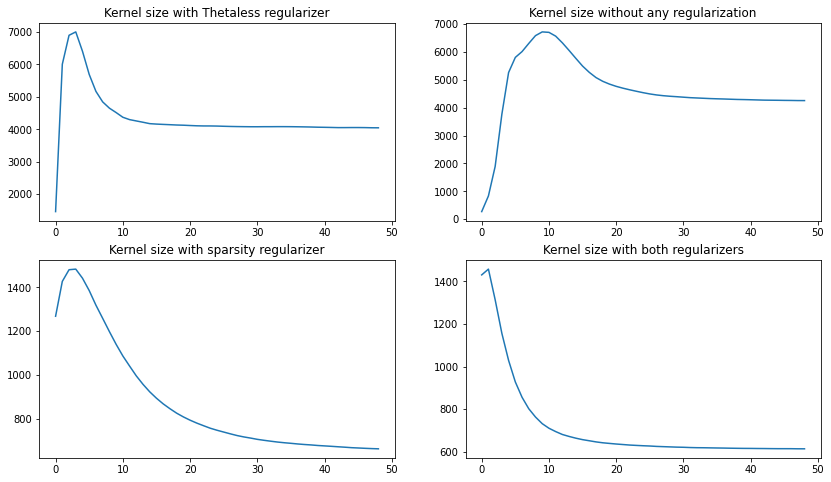

In [22]:
plot_metric(view_name='kernel', value_name='average_size', title_name='Kernel size')

Last values:
	thetaless – 1.6930015502023317
	plsa – 1.5415081854659372
	sparse – 1.4994938821199244
	sparse_thetaless – 1.6034352180930274
	


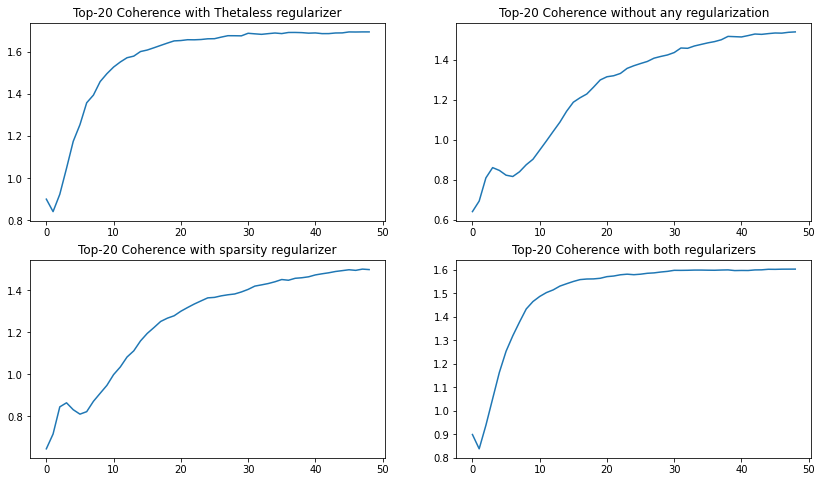

In [23]:
plot_metric(view_name='coherence_ppmi', value_name='value', title_name='Top-20 Coherence')

## Coherence evaluation on an external corpus (with Palmetto)

Unfortunately, the service isn't available right now

In [ ]:
def eval_top_words(name, model, num_top_tokens=10):
    ttv = TopTokensViewer(model, method='blei', num_top_tokens=num_top_tokens)
    output = ttv.view()
    S = "http://palmetto.aksw.org/palmetto-webapp/service/{}?words=".format("umass")
    topic_score = []

    for key, modalities in output.items():
        if 'topic' in key:
            words = list(output[key]['@default_class'].keys())

            print(S + "%20".join(words))

            result = requests.get(S + "%20".join(words)).text
            topic_score += [float(result)]

    print(round(np.mean(topic_score), 2), round(np.median(topic_score), 2))

In [ ]:
# eval_top_words('thetaless', thetaless_model)

In [ ]:
# eval_top_words('plsa', plsa_model)

In [ ]:
# eval_top_words('sparse', sparse_model)

In [ ]:
# eval_top_words('sparse_thetaless', sparse_thetaless_model)

## Let's look at topics

In [24]:
def print_top_words(name, model, num_top_tokens=10):
    ttv = TopTokensViewer(model, method='blei', num_top_tokens=num_top_tokens)
    output = ttv.view()

    for key, modalities in output.items():
        if 'topic' in key:
            print(', '.join(output[key][MAIN_MODALITY].keys()))
            print()

In [25]:
print_top_words('thetaless', thetaless_model)

space, earth, launch, project, mission, nasa, satellite, station, orbit, degree

car, light, bike, ground, engine, front, ride, mile, road, wire

game, play, team, win, player, hit, season, lose, fan, league

system, mail, send, list, software, computer, user, address, email, package

find, question, many, post, read, write, name, follow, book, must

also, high, power, large, small, low, offer, control, full, add

key, information, chip, public, message, encryption, technology, security, clipper, algorithm

run, work, window, thank, problem, please, help, set, appreciate, driver

use, need, number, line, order, buy, price, sell, require, check

drive, card, disk, mac, board, hard, mb, monitor, ms, memory

study, drug, effect, medical, disease, patient, doctor, food, ed, health

one, get, think, good, seem, really, put, hear, probably, much

x, output, function, entry, widget, sun, motif, define, return, include

believe, claim, fact, true, exist, evidence, agree, matter, argument, reli

In [26]:
print_top_words('plsa', plsa_model)

space, launch, earth, project, mission, nasa, satellite, orbit, system, station

car, bike, turn, power, light, ground, engine, back, front, ride

year, game, last, win, play, lose, team, hit, player, guy

system, mail, software, computer, list, user, pc, support, mac, package

question, post, read, find, many, book, write, different, answer, article

also, high, work, small, offer, large, time, several, low, interested

key, public, information, message, chip, encryption, system, security, clipper, private

window, run, thank, anyone, work, problem, help, please, use, get

use, number, call, line, need, sell, price, may, order, phone

drive, card, disk, hard, board, system, mb, speed, fast, scsi

effect, cause, drug, study, medical, disease, patient, increase, doctor, food

one, think, get, seem, good, really, hear, come, though, talk

x, server, output, include, file, application, entry, widget, sun, program

believe, people, true, exist, argument, religion, fact, matter, agree, beli

In [27]:
print_top_words('sparse', sparse_model)

space, center, science, research, launch, design, project, cost, material, mission

get, good, back, turn, buy, need, stuff, little, bike, anybody

year, game, last, team, play, win, player, lose, guy, next

system, computer, software, mail, machine, user, mac, base, memory, monitor

question, post, read, write, answer, must, article, different, message, bit

number, also, high, small, large, several, open, case, use, type

key, information, chip, use, group, provide, may, encryption, security, clipper

use, work, problem, run, please, anyone, help, thank, need, set

use, new, call, price, sell, offer, check, include, interested, box

drive, card, hard, disk, power, speed, board, sound, driver, mb

effect, condition, hit, soon, disease, patient, compare, mile, low, year

think, one, seem, much, hear, though, idea, see, really, put

x, list, send, line, copy, include, name, source, output, code

believe, people, true, church, christian, argument, fact, israel, jews, agree

kill, people,

In [28]:
print_top_words('sparse_thetaless', sparse_thetaless_model)

space, earth, science, design, center, launch, field, project, material, mission

get, good, back, power, buy, around, big, turn, stuff, light

year, game, last, play, team, win, player, lose, guy, season

system, mail, software, support, computer, machine, user, pc, standard, contact

question, post, read, write, follow, must, ask, different, bit, note

also, number, high, source, large, several, small, add, build, require

key, information, chip, provide, phone, use, service, order, encryption, technology

use, work, problem, need, run, please, help, thank, anyone, window

new, call, include, price, etc, sell, offer, check, pay, cost

drive, card, disk, driver, hard, speed, board, mb, fast, ms

effect, condition, medical, soon, disease, compare, patient, mile, average, ed

one, think, much, seem, really, still, put, hear, sure, probably

x, send, list, line, copy, 25, output, return, section, request

believe, people, true, fact, church, agree, argument, matter, israel, jews

kill, m

## Last coherence values (using different number of top tokens)

The plots above show how the coherence (PPMI) of top 20 tokens evolves. In addition, we can look at the last PMI and PPMI values using different sizes of top-token list (5, 10, 20, 50, 100 words)

In [29]:
occurences, co_occurences = calc_doc_occurrences(dataset, MAIN_MODALITY)

calc_pmi = create_pmi_top_function(
    occurences, co_occurences,
    dataset.get_dataset().shape[0], [5, 10, 20, 50, 100],
    co_occurrences_smooth=1e-2
)

In [30]:
calc_pmi(plsa_model.get_phi_dense()[0].T)

(array([1.21499297, 1.41841121, 1.4773908 , 1.64972323, 1.70756978]),
 array([1.31236076, 1.47163629, 1.54150819, 1.69634847, 1.80704321]))

In [31]:
calc_pmi(thetaless_model.get_phi_dense()[0].T)

(array([1.57331496, 1.62475971, 1.65381981, 1.86711067, 1.87356811]),
 array([1.57331496, 1.62499837, 1.69300155, 1.94859555, 2.09445053]))

In [32]:
calc_pmi(sparse_model.get_phi_dense()[0].T)

(array([1.35890928, 1.35700836, 1.48383579, 1.59996205, 1.60108423]),
 array([1.35890928, 1.37848896, 1.49985511, 1.65918859, 1.78920465]))

In [33]:
calc_pmi(sparse_thetaless_model.get_phi_dense()[0].T)

(array([1.42275237, 1.48636823, 1.59154109, 1.75142554, 1.55162446]),
 array([1.42275237, 1.48636823, 1.60343522, 1.83606053, 1.9786894 ]))

In [ ]:
# TODO: Also, let's take a look at train + test together, instead of relying on train only:

## Conclusion

We observed several interesting things.

1) the regularizer improves coherence and sparsity without explicitly optimizing for it

2) The regularizer moves common but uninformative words away from "informative" topics. Compare the 3rd topic of PLSA: 

`year, game, last, win, play, lose, team, hit, player, guy`

with the corresponding topic of Thetaless:

`game, play, team, win, player, hit, season, lose, fan, league`

If we look at 20th topic, we will see the reverse trend.

The topic of PLSA is uninformative with a few meaningful words thrown in:

`make, even, may, case, consider, fire, less, mean, long, force`

The corresponding topic of Thetaless consist of common parlance almost entirely, without any signal lost in noise.

`make, point, even, case, mean, keep, long, actually, consider, every`

It should be noted that we had not specified the usual distincton between specific and background topics, the separation here is purely emergent.
